In [1]:
!pip install pystac_client==0.6.1 stackstac==0.4.4

  Obtaining dependency information for stackstac==0.4.4 from https://files.pythonhosted.org/packages/81/22/3bb47276aa898638fcaf24bd73db6acc8249cfaccb6b1021e579045c1868/stackstac-0.4.4-py3-none-any.whl.metadata
  Obtaining dependency information for pystac>=1.7.0 from https://files.pythonhosted.org/packages/d9/33/528355f091d6522e5f11e02b1309cb4713e21ef8f772dd9b38e8276da011/pystac-1.8.4-py3-none-any.whl.metadata
  Obtaining dependency information for dask[array]>=2022.1.1 from https://files.pythonhosted.org/packages/f5/ec/3613b5221a015f54ff50a948029bbd7564e846a45178070feced8b9d105c/dask-2023.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec>=2021.09.0 from https://files.pythonhosted.org/packages/fe/d3/e1aa96437d944fbb9cc95d0316e25583886e9cd9e6adc07baad943524eda/fsspec-2023.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for partd>=1.2.0 from https://files.pythonhosted.org/packages/11/8a/b7a58e208b144a7315208a0dd627e23f5f50b47fa89c2924bb2e9238ecf

In [2]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

In [3]:
import pystac_client
import stackstac

In [4]:
bbox = Box(ymin=23.612709, xmin=58.361626, ymax=23.556148, xmax=58.429526).normalize()
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
bbox

Box(ymin=23.556148, xmin=58.361626, ymax=23.612709, xmax=58.429526)

In [5]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2017-01-01/2023-12-31",
    # datetime="2022-01-01/2023-12-31",
    query={"eo:cloud_cover": {"lt": 5}},
).item_collection()
len(items)

265

In [6]:
stack = stackstac.stack(items)
stack

<xarray.DataArray 'stackstac-7d8a0854389e4e5f10dd77f46fa286a5' (time: 265,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(265, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-01...
    id                                       (time) <U24 'S2A_40QFM_20170101_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 6e+05 ... 7.098e+05
  * y                                        (y) float64 2.7e+06 ... 2.59e+06
    s2:unclassified_percentage               (time) float64 0.5225 ... 0.003597
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32640
Attributes:
    spec:        RasterSpec(epsg=32640, bounds=(600000.0, 2590200.0, 709800.0...
    crs:         epsg:32640
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 2700000.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [7]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir09', # B09
        'swir16', # ???
        'swir16', # B11
        'swir22', # B12
        'nir08', # B8A
    ])

### Create the `RasterSource`

In [8]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

In [9]:
xmin_px, ymin_px = crs_transformer.map_to_pixel((bbox.xmin, bbox.ymin))
valid_ts, _ = np.where(~np.isnan(data_array.isel(x=xmin_px, y=ymin_px, band=[0]).to_numpy()))
data_array = data_array.isel(time=valid_ts)
data_array

<xarray.DataArray 'stackstac-7d8a0854389e4e5f10dd77f46fa286a5' (time: 265,
                                                                band: 13,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(265, 13, 10980, 10980), dtype=float64, chunksize=(1, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-01...
    id                                       (time) <U24 'S2A_40QFM_20170101_...
  * band                                     (band) <U12 'coastal' ... 'nir08'
  * x                                        (x) float64 6e+05 ... 7.098e+05
  * y                                        (y) float64 2.7e+06 ... 2.59e+06
    s2:unclassified_percentage               (time) float64 0.5225 ... 0.003597
    ...                                       ...
    title                                    (band) <U31 'Coastal aerosol (ba...
    gsd                                      (band) object 60 10 10 ... 20 20 20
    common_name                              (band) object 'coastal' ... 'nir08'
    center_wavelength                        (band) object 0.443 0.49 ... 0.865
    full_width_half_max                      (band) object 0.027 0.098 ... 0.033
    epsg                                     int64 32640
Attributes:
    spec:        RasterSpec(epsg=32640, bounds=(600000.0, 2590200.0, 709800.0...
    crs:         epsg:32640
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 2700000.00|\n| 0.0...
    resolution:  10.0

In [9]:
# means = np.array([756.4, 889.6, 1151.7, 1307.6, 1637.6, 2212.6, 2442.0, 2538.9, 2602.9, 2666.8, 2388.8, 2388.8, 1821.5])
# stds = np.array([1111.4, 1159.1, 1188.1, 1375.2, 1376.6, 1358.6, 1418.4, 1476.4, 1439.9, 1582.1, 1460.7, 1460.7, 1352.2])
# stats = RasterStats(means, stds)
# stats.save('SSL4EO_stats.json')

In [10]:
stats_tf = StatsTransformer.from_stats_json('SSL4EO_stats.json')

In [18]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=[3, 2, 1],
    temporal=True
)
raster_source.shape

(265, 10980, 10980, 3)

In [19]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

In [213]:
# window = raster_source.crs_transformer.map_to_pixel(bbox).normalize()
# window.extent
window = Box(ymin=8900, xmin=4150, ymax=9150, xmax=4450)
window.extent

Box(ymin=0, xmin=0, ymax=250, xmax=300)

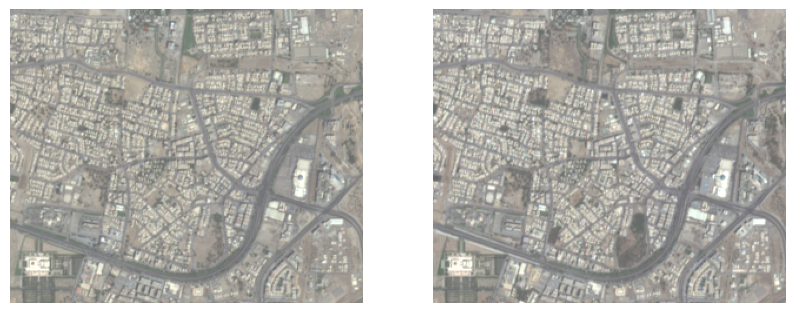

In [214]:
img1 = raster_source.get_chip(window, time=np.where(t_strs == '2019-09-18')[0].squeeze())
img2 = raster_source.get_chip(window, time=np.where(t_strs == '2023-09-12')[0].squeeze())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img1)
ax2.imshow(img2)
ax1.axis('off')
ax2.axis('off')
plt.show()

---

In [10]:
bbox = Box(ymin=23.5170057, xmin=58.2066668, ymax=23.6448968, xmax=58.6326003)
bbox_pixel_coords = crs_transformer.map_to_pixel(bbox).normalize()

In [11]:
stats_path_cd = 's3://raster-vision-ahassan/oscd/cd_blog/blog_4/analyze/stats/train_scenes/stats.json'
stats_tf_cd = StatsTransformer.from_stats_json(stats_path_cd)

In [12]:
stats_tf_cd.means[9] = stats_tf_cd.means[10]
stats_tf_cd.stds[9] = stats_tf_cd.stds[10]

stats_tf_cd.means[9 + 13] = stats_tf_cd.means[10 + 13]
stats_tf_cd.stds[9 + 13] = stats_tf_cd.stds[10 + 13]

In [13]:
stats_tf_cd.means[:13], stats_tf_cd.means[13:]

(array([1551.92119778, 1336.64289556, 1232.53053333, 1247.29935   ,
        1372.6935    , 1746.66172111, 1931.13684667, 1852.98324778,
         632.88502778, 1890.14376778, 1890.14376778, 1415.96799   ,
        2040.28074667]),
 array([1579.64002556, 1365.02697444, 1262.13693222, 1267.83389667,
        1395.23131667, 1815.94603889, 2033.93776778, 1942.22679111,
         631.97060444, 1906.35015   , 1906.35015   , 1416.06268333,
        2149.28212222]))

In [14]:
t_strs = np.array(['2017-01-01', '2017-01-11', '2017-02-10', '2017-04-01',
       '2017-04-11', '2017-04-21', '2017-05-31', '2017-08-04',
       '2017-08-14', '2017-08-24', '2017-09-08', '2017-09-18',
       '2017-09-23', '2017-09-28', '2017-10-03', '2017-10-08',
       '2017-10-13', '2017-10-18', '2017-10-23', '2017-10-28',
       '2017-11-02', '2017-11-07', '2017-11-22', '2017-11-27',
       '2017-12-02', '2017-12-07', '2017-12-12', '2017-12-22',
       '2018-01-01', '2018-01-06', '2018-01-11', '2018-01-21',
       '2018-01-26', '2018-02-15', '2018-03-07', '2018-03-12',
       '2018-03-22', '2018-03-27', '2018-04-01', '2018-04-06',
       '2018-04-16', '2018-04-21', '2018-04-26', '2018-05-06',
       '2018-05-31', '2018-09-03', '2018-09-08', '2018-09-18',
       '2018-09-23', '2018-09-28', '2018-10-03', '2018-10-08',
       '2018-10-13', '2018-10-23', '2018-10-28', '2018-11-07',
       '2018-11-12', '2018-12-07', '2018-12-12', '2018-12-17',
       '2018-12-22', '2019-01-01', '2019-01-06', '2019-01-16',
       '2019-01-26', '2019-01-31', '2019-02-10', '2019-02-15',
       '2019-03-12', '2019-04-16', '2019-04-21', '2019-04-26',
       '2019-05-01', '2019-05-16', '2019-06-25', '2019-07-20',
       '2019-08-04', '2019-08-19', '2019-08-24', '2019-09-13',
       '2019-09-18', '2019-09-28', '2019-10-03', '2019-10-08',
       '2019-10-18', '2019-10-23', '2019-10-28', '2019-11-07',
       '2019-11-12', '2019-12-02', '2019-12-22', '2020-01-16',
       '2020-01-21', '2020-02-05', '2020-02-10', '2020-02-15',
       '2020-02-25', '2020-03-01', '2020-03-06', '2020-03-11',
       '2020-03-31', '2020-03-31', '2020-04-10', '2020-04-20',
       '2020-04-20', '2020-04-25', '2020-06-04', '2020-06-04',
       '2020-06-24', '2020-06-24', '2020-07-14', '2020-07-14',
       '2020-07-24', '2020-07-24', '2020-08-18', '2020-08-18',
       '2020-09-07', '2020-09-07', '2020-09-12', '2020-09-12',
       '2020-09-17', '2020-09-17', '2020-09-22', '2020-09-27',
       '2020-10-02', '2020-10-07', '2020-10-07', '2020-10-12',
       '2020-10-17', '2020-10-22', '2020-10-27', '2020-11-01',
       '2020-11-06', '2020-11-06', '2020-11-11', '2020-11-16',
       '2020-11-16', '2020-11-21', '2020-12-01', '2020-12-01',
       '2020-12-06', '2020-12-06', '2020-12-21', '2020-12-31',
       '2020-12-31', '2021-01-05', '2021-01-05', '2021-01-10',
       '2021-01-10', '2021-01-15', '2021-01-20', '2021-01-25',
       '2021-01-25', '2021-01-30', '2021-02-04', '2021-02-24',
       '2021-02-24', '2021-03-01', '2021-03-01', '2021-03-06',
       '2021-03-06', '2021-03-11', '2021-03-11', '2021-03-21',
       '2021-03-21', '2021-03-26', '2021-03-26', '2021-03-31',
       '2021-03-31', '2021-04-05', '2021-04-05', '2021-04-05',
       '2021-04-10', '2021-04-10', '2021-04-15', '2021-04-15',
       '2021-04-20', '2021-04-20', '2021-04-25', '2021-04-25',
       '2021-05-20', '2021-05-20', '2021-06-24', '2021-06-29',
       '2021-08-03', '2021-08-03', '2021-08-28', '2021-09-02',
       '2021-09-17', '2021-09-22', '2021-09-22', '2021-09-27',
       '2021-09-27', '2021-10-07', '2021-10-07', '2021-10-12',
       '2021-10-12', '2021-10-17', '2021-10-17', '2021-10-22',
       '2021-10-22', '2021-11-01', '2021-11-06', '2021-11-11',
       '2021-11-16', '2021-11-21', '2021-11-26', '2021-12-01',
       '2021-12-06', '2021-12-11', '2022-01-30', '2022-02-04',
       '2022-02-09', '2022-02-19', '2022-02-24', '2022-03-01',
       '2022-03-06', '2022-03-16', '2022-03-21', '2022-03-26',
       '2022-03-31', '2022-04-20', '2022-04-25', '2022-05-05',
       '2022-05-10', '2022-05-15', '2022-06-04', '2022-08-28',
       '2022-09-12', '2022-09-17', '2022-10-02', '2022-10-07',
       '2022-10-12', '2022-10-22', '2022-10-27', '2022-11-01',
       '2022-11-11', '2022-11-16', '2022-11-26', '2022-12-16',
       '2022-12-26', '2022-12-31', '2023-01-05', '2023-01-10',
       '2023-01-15', '2023-01-30', '2023-02-04', '2023-02-09',
       '2023-02-14', '2023-02-24', '2023-03-06', '2023-03-21',
       '2023-03-26', '2023-03-31', '2023-04-05', '2023-04-10',
       '2023-04-15', '2023-07-19', '2023-08-03', '2023-08-08',
       '2023-08-13', '2023-08-28', '2023-09-07', '2023-09-12',
       '2023-09-27'], dtype='<U10')

In [16]:
bbox_pixel_coords = Box(ymin=8413, xmin=2319, ymax=9413, xmax=3319)

In [17]:
raster_source_old = XarraySource(
    data_array.isel(time=np.where(t_strs == '2019-09-18')[0].squeeze()),
    crs_transformer=crs_transformer,
    bbox=bbox_pixel_coords,
)
raster_source_old.shape

(1000, 1000, 13)

In [18]:
raster_source_new = XarraySource(
    data_array.isel(time=np.where(t_strs == '2023-09-12')[0].squeeze()),
    crs_transformer=crs_transformer,
    bbox=bbox_pixel_coords,
)
raster_source_new.shape

(1000, 1000, 13)

In [28]:
# stats_tf_cd = StatsTransformer.from_raster_sources([raster_source_old, raster_source_new], sample_prob=0.1)
# stats_tf_cd.means = np.concatenate([stats_tf_cd.means, stats_tf_cd.means])
# stats_tf_cd.stds = np.concatenate([stats_tf_cd.stds, stats_tf_cd.stds])
# stats_tf_cd

Analyzing chips: 0it [00:00, ?it/s]

StatsTransformer(means=array([1253.35471667, 1547.45679286, 2027.38915556, 2477.8633746 ,
       2702.60681429, 2734.74933492, 2814.01410873, 2791.58989127,
       2829.4291754 , 3298.03985238, 3298.03985238, 2902.40438492,
       2813.39685556, 1253.35471667, 1547.45679286, 2027.38915556,
       2477.8633746 , 2702.60681429, 2734.74933492, 2814.01410873,
       2791.58989127, 2829.4291754 , 3298.03985238, 3298.03985238,
       2902.40438492, 2813.39685556]), std=array([ 352.88281348,  510.80882648,  683.70618902,  894.53396516,
        946.15814752,  940.72565792,  970.99662315,  985.43797129,
        927.68795842, 1278.77479634, 1278.77479634, 1115.83369327,
        967.87037385,  352.88281348,  510.80882648,  683.70618902,
        894.53396516,  946.15814752,  940.72565792,  970.99662315,
        985.43797129,  927.68795842, 1278.77479634, 1278.77479634,
       1115.83369327,  967.87037385]), max_stds=3.0)

In [22]:
stats_tf_cd = StatsTransformer(means=np.array([1253.35471667, 1547.45679286, 2027.38915556, 2477.8633746 ,
       2702.60681429, 2734.74933492, 2814.01410873, 2791.58989127,
       2829.4291754 , 3298.03985238, 3298.03985238, 2902.40438492,
       2813.39685556, 1253.35471667, 1547.45679286, 2027.38915556,
       2477.8633746 , 2702.60681429, 2734.74933492, 2814.01410873,
       2791.58989127, 2829.4291754 , 3298.03985238, 3298.03985238,
       2902.40438492, 2813.39685556]), stds=np.array([ 352.88281348,  510.80882648,  683.70618902,  894.53396516,
        946.15814752,  940.72565792,  970.99662315,  985.43797129,
        927.68795842, 1278.77479634, 1278.77479634, 1115.83369327,
        967.87037385,  352.88281348,  510.80882648,  683.70618902,
        894.53396516,  946.15814752,  940.72565792,  970.99662315,
        985.43797129,  927.68795842, 1278.77479634, 1278.77479634,
       1115.83369327,  967.87037385]), max_stds=3.0)

In [23]:
from rastervision.core.data import MultiRasterSource

raster_source_cd = MultiRasterSource(
    raster_sources=[raster_source_old, raster_source_new],
    raster_transformers=[stats_tf_cd],
)
raster_source_cd.shape

(1000, 1000, 26)

In [24]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

bundle_uri = 'model-bundle/model-bundle.zip'
learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

2023-09-28 01:29:25:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle model-bundle/model-bundle.zip.
2023-09-28 01:29:25:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmp8ia_63zm/model-bundle
2023-09-28 01:29:25:rastervision.pytorch_learner.learner: INFO - Using model definition found in bundle: /opt/data/tmp/tmp8ia_63zm/model-bundle/modules/fpn
2023-09-28 01:29:25:rastervision.pytorch_learner.learner_config: INFO - Using existing module definition at: /opt/data/tmp/tmp8ia_63zm/model-bundle/modules/fpn
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 28.4MB/s]
2023-09-28 01:29:27:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmp8ia_63zm/mode

In [25]:
import albumentations as A

tf = A.Resize(256, 256)

In [30]:
window = Box(ymin=500, xmin=500, ymax=600, xmax=600)
chip = raster_source_cd.get_chip(window)
chip.shape

(100, 100, 26)

In [31]:
import torch

x = tf(image=chip)['image']
x = torch.from_numpy(x).float().permute(2, 0, 1).unsqueeze(0)
x /= 255
x.shape

torch.Size([1, 26, 256, 256])

In [32]:
out = learner.predict(x, raw_out=True, out_shape=(100, 100)).cpu()
out.shape

torch.Size([1, 2, 100, 100])

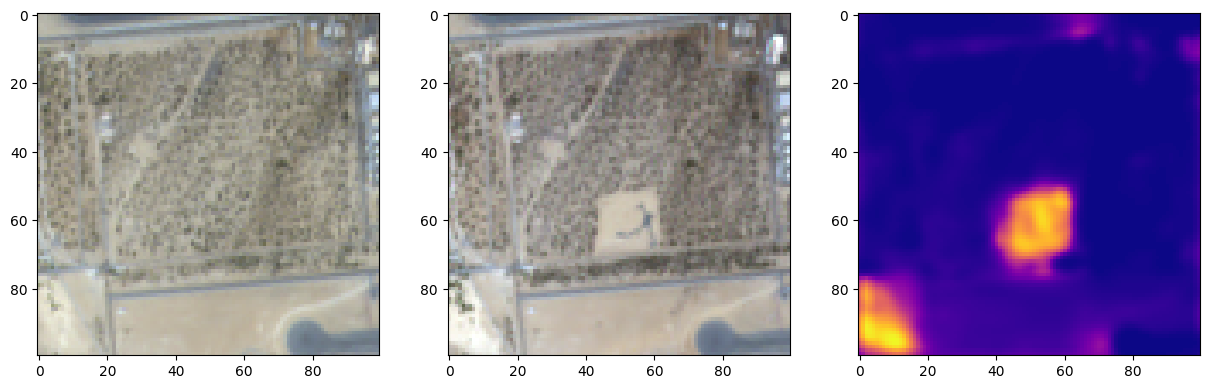

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
ax1.imshow(chip[..., [3, 2, 1]])
ax2.imshow(chip[..., [16, 15, 14]])
ax3.imshow(out[0, 1], cmap='plasma')
# ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')
plt.show()

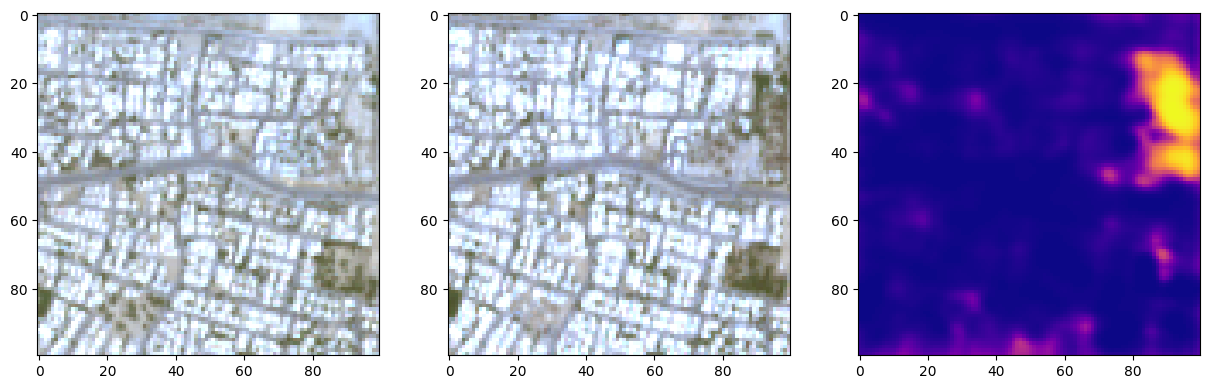

In [291]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
ax1.imshow(chip[..., [3, 2, 1]])
ax2.imshow(chip[..., [16, 15, 14]])
ax3.imshow(out[0, 1], cmap='plasma')
# ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')
plt.show()

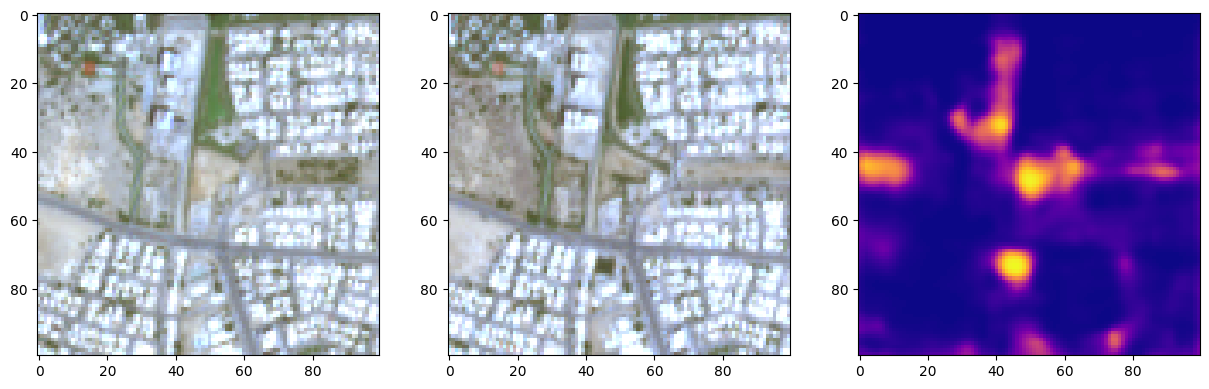

In [333]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
ax1.imshow(chip[..., [3, 2, 1]])
ax2.imshow(chip[..., [16, 15, 14]])
ax3.imshow(out[0, 1], cmap='plasma')
# ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')
plt.show()

---

In [34]:
from rastervision.core.box import Box
from rastervision.core.data import (
    ClassConfig, RasterioCRSTransformer, Scene, SemanticSegmentationLabels,
    StatsTransformer, XarraySource)
from rastervision.core.data.utils import (get_polygons_from_uris)
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from shapely.geometry import mapping
import pystac_client
import stackstac

In [35]:
class_config = ClassConfig(names=['no change', 'change'])

In [36]:
aoi_polygons = get_polygons_from_uris('../aoi_Muscat.json', crs_transformer)
scene = Scene(
    id='test_scene',
    raster_source=raster_source_cd,
    aoi_polygons=aoi_polygons,
)

In [37]:
pred_ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene=scene, 
    size=100, 
    stride=50, 
    transform=A.Resize(256, 256),
)
len(pred_ds)

400

In [41]:
_ = scene.raster_source.raster_sources[0].data_array.load()
_ = scene.raster_source.raster_sources[1].data_array.load()


KeyboardInterrupt



In [43]:
predictions = learner.predict_dataset(
    pred_ds,
    raw_out=True,
    numpy_out=True,
    progress_bar=True,
    dataloader_kw=dict(num_workers=0),
)
labels = SemanticSegmentationLabels.from_predictions(
    pred_ds.windows, 
    predictions,
    smooth=True,
    extent=scene.extent,
    num_classes=len(class_config),
    crop_sz=10,
)

Predicting:   0%|          | 0/400 [00:00<?, ?it/s]


KeyboardInterrupt



In [28]:
labels.save(
    'eurosat/predict/muscat.json', 
    class_config, 
    crs_transformer, 
    bbox=raster_source.bbox)